<a href="https://colab.research.google.com/github/shijuc/CGAN_Demo/blob/master/CGAN_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from __future__ import division, print_function
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
import itertools
import time
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import cv2
from PIL import Image
from sklearn.metrics import confusion_matrix
from keras.preprocessing import image
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, Flatten, GlobalAveragePooling2D, BatchNormalization, Dropout, Conv2D, Conv2DTranspose, AveragePooling2D, MaxPooling2D, UpSampling2D, Input, Reshape, Lambda, Concatenate, Subtract, Reshape, multiply
from keras.layers import Embedding, ZeroPadding2D
from keras.regularizers import l2
from keras.layers import LeakyReLU
from keras import backend as K
from keras.optimizers import Nadam, Adam, SGD
from keras.metrics import categorical_accuracy, binary_accuracy
from keras.callbacks import Callback, History
import tensorflow as tf
import pandas as pd
import glob
import PIL
from sys import getsizeof
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib.ticker import MaxNLocator
from sklearn.utils import class_weight
from keras.datasets import mnist

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# Image shape information
img_rows = X_train.shape[1]
img_cols = X_train.shape[2]

if len(X_train.shape) == 4:
    channels = X_train.shape[3]
else:
    channels = 1
img_shape = (img_rows, img_cols, channels)
num_classes = 10
latent_dim = 100
optimizer = Adam(0.0002, 0.5)

11490434/11490434 [==============================] - 1s 0us/step


In [4]:
def discriminator():
    model = Sequential()
    model.add(Dense(512, input_dim=np.prod(img_shape)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    img = Input(shape=img_shape)
    label = Input(shape=(1,), dtype='int32')

    label_embedding = Flatten()(Embedding(num_classes, np.prod(img_shape))(label))
    flat_img = Flatten()(img)

    model_input = multiply([flat_img, label_embedding])

    validity = model(model_input)

    return Model([img, label], validity)

In [5]:
def generator():
    model = Sequential()
    model.add(Dense(256, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))
    model.summary()

    noise = Input(shape=(latent_dim,))
    label = Input(shape=(1,), dtype='int32')
    label_embedding = Flatten()(Embedding(num_classes, latent_dim)(label))

    model_input = multiply([noise, label_embedding])
    img = model(model_input)

    return Model([noise, label], img)

In [6]:
discriminator = discriminator()

discriminator.compile(loss=['binary_crossentropy'], optimizer=optimizer, metrics=['accuracy'])

# Build the generator
generator = generator()

# The generator takes noise and the target label as input
# and generates the corresponding digit of that label

noise = Input(shape=(latent_dim,))
label = Input(shape=(1,))
img = generator([noise, label])

# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated image as input and determines validity
# and the label of that image
valid = discriminator([img, label])

# The combined model  (stacked generator and discriminator)
# Trains generator to fool discriminator

combined = Model([noise, label], valid)
combined.compile(loss=['binary_crossentropy'], optimizer=optimizer)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 512)               0

In [7]:
def sample_images(epoch):
    r, c = 2, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    sampled_labels = np.arange(0, 10).reshape(-1, 1)
    for i in range(0, len(sampled_labels)):
        print(sampled_labels[i])
    gen_imgs = generator.predict([noise, sampled_labels])

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    cnt = 0
    for i in range(2 * 5):
      plt.axis('off')
      plt.imshow(gen_imgs[cnt,:,:,0], cmap='gray')
      cnt += 1
      filename = "/content/%d" % sampled_labels[cnt-1]

      if not os.path.exists(filename):
          os.makedirs(filename)
      plt.savefig("/content/%d/%d.png" % ( sampled_labels[cnt-1], epoch))

    plt.close()


In [8]:
epochs=5000
batch_size=32
sample_interval=500

In [9]:
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=3)

y_train = y_train.reshape(-1, 1)

# Adversarial ground truths
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

# Declaring empty lists to save the losses for plotting
d_loss_plot = []
g_loss_plot = []
acc_plot = []

1/1 [==============================] - 4s 4s/step
0/5000 [D loss: 0.695794, acc.: 20.31%] [G loss: 0.687030]
1/1 [==============================] - 0s 118ms/step


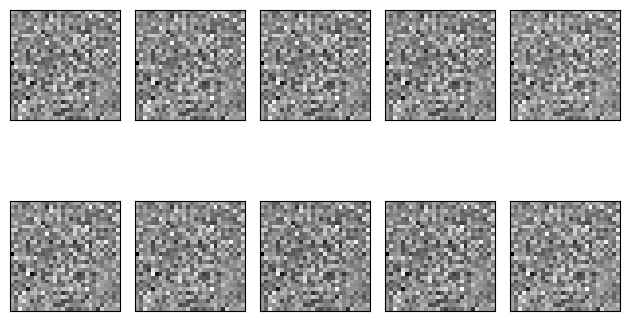

[0]
[1]
[2]
[3]
[4]
[5]
[6]
[7]
[8]
[9]
1/1 [==============================] - 0s 18ms/step
500/5000 [D loss: 0.489971, acc.: 73.44%] [G loss: 1.547397]
1/1 [==============================] - 0s 19ms/step


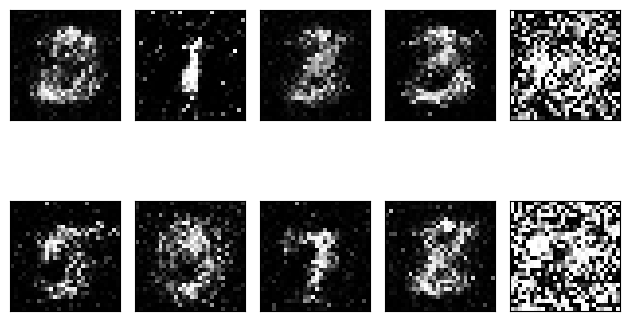

[0]
[1]
[2]
[3]
[4]
[5]
[6]
[7]
[8]
[9]
1/1 [==============================] - 0s 21ms/step
1000/5000 [D loss: 0.662878, acc.: 59.38%] [G loss: 1.447932]
1/1 [==============================] - 0s 28ms/step


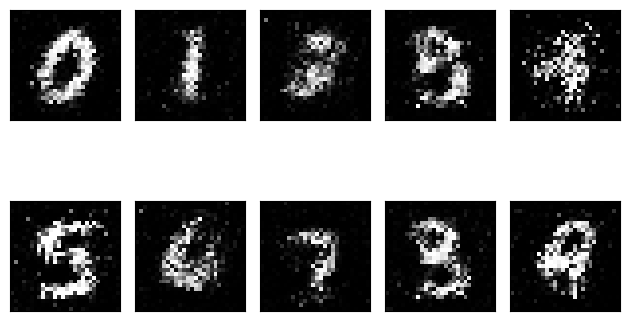

[0]
[1]
[2]
[3]
[4]
[5]
[6]
[7]
[8]
[9]
1/1 [==============================] - 0s 23ms/step
1500/5000 [D loss: 0.612144, acc.: 68.75%] [G loss: 1.372270]
1/1 [==============================] - 0s 29ms/step


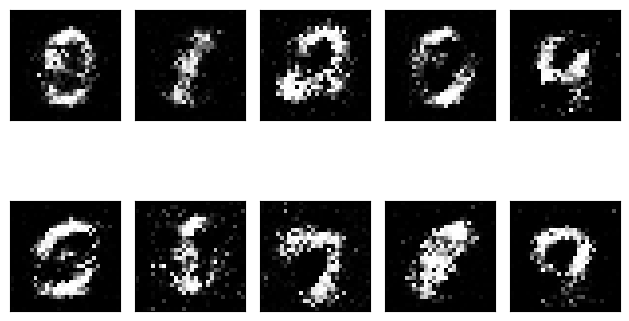

[0]
[1]
[2]
[3]
[4]
[5]
[6]
[7]
[8]
[9]
1/1 [==============================] - 0s 17ms/step
2000/5000 [D loss: 0.670774, acc.: 59.38%] [G loss: 0.936489]
1/1 [==============================] - 0s 20ms/step


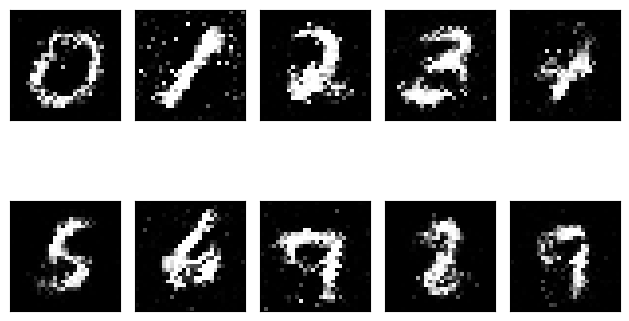

[0]
[1]
[2]
[3]
[4]
[5]
[6]
[7]
[8]
[9]
1/1 [==============================] - 0s 20ms/step
2500/5000 [D loss: 0.742040, acc.: 50.00%] [G loss: 0.938138]
1/1 [==============================] - 0s 30ms/step


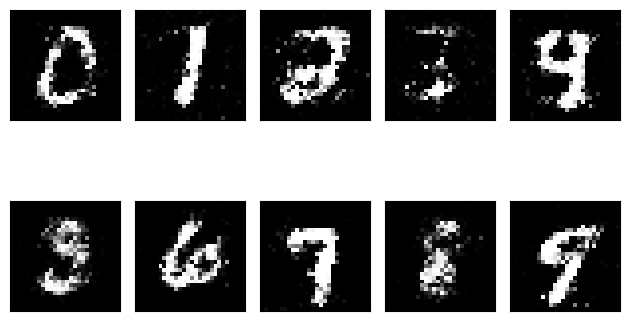

[0]
[1]
[2]
[3]
[4]
[5]
[6]
[7]
[8]
[9]
1/1 [==============================] - 0s 19ms/step
3000/5000 [D loss: 0.633706, acc.: 60.94%] [G loss: 0.825467]
1/1 [==============================] - 0s 28ms/step


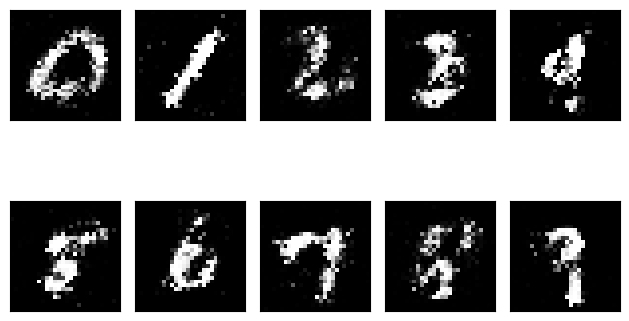

[0]
[1]
[2]
[3]
[4]
[5]
[6]
[7]
[8]
[9]
1/1 [==============================] - 0s 18ms/step
3500/5000 [D loss: 0.688793, acc.: 50.00%] [G loss: 0.857102]
1/1 [==============================] - 0s 27ms/step


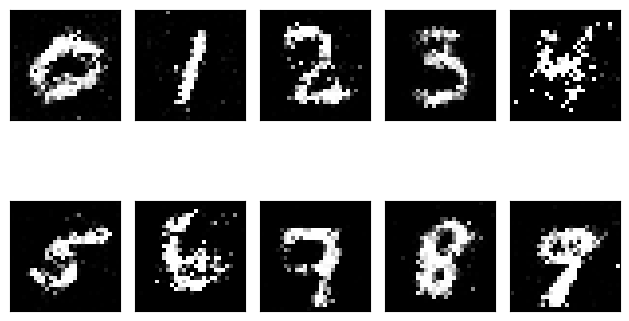

[0]
[1]
[2]
[3]
[4]
[5]
[6]
[7]
[8]
[9]
1/1 [==============================] - 0s 20ms/step
4000/5000 [D loss: 0.654098, acc.: 57.81%] [G loss: 0.760019]
1/1 [==============================] - 0s 27ms/step


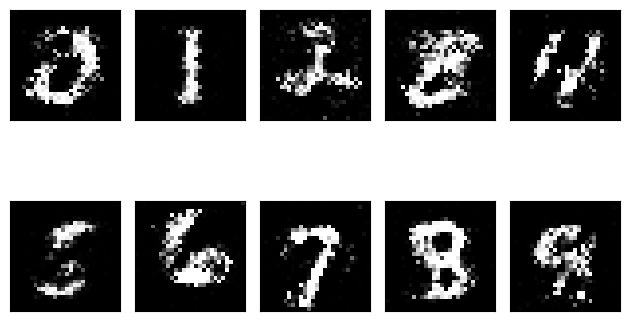

[0]
[1]
[2]
[3]
[4]
[5]
[6]
[7]
[8]
[9]
1/1 [==============================] - 0s 18ms/step
4500/5000 [D loss: 0.644949, acc.: 59.38%] [G loss: 0.813310]
1/1 [==============================] - 0s 28ms/step


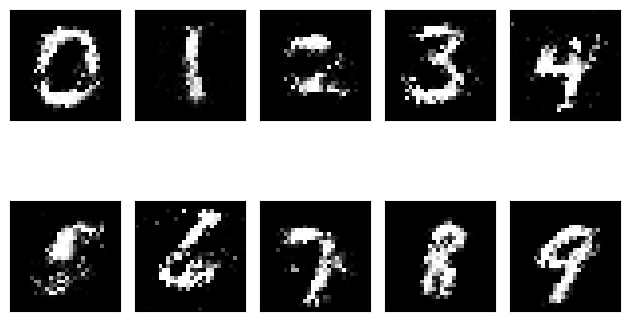

[0]
[1]
[2]
[3]
[4]
[5]
[6]
[7]
[8]
[9]
1/1 [==============================] - 0s 17ms/step


In [10]:
for epoch in range(epochs):
    #Training the Discriminator
    # Select a random half batch of images
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs, labels = X_train[idx], y_train[idx]

    # Sample noise as generator input
    noise = np.random.normal(0, 1, (batch_size, 100))

    # Generate a half batch of new images
    gen_imgs = generator.predict([noise, labels])

    # Train the discriminator
    d_loss_real = discriminator.train_on_batch([imgs, labels], valid)
    d_loss_fake = discriminator.train_on_batch([gen_imgs, labels], fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    #Training the Generator
    # Condition on labels
    sampled_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)

    # Train the generator
    g_loss = combined.train_on_batch([noise, sampled_labels], valid)

    # Saving the Discriminator and Generator losses and accuracy for plotting
    d_loss_plot.append(d_loss[0])
    g_loss_plot.append(g_loss)
    acc_plot.append(d_loss[1])

    # Plot the progress every 500 epochs
    if epoch % 500 == 0:
        print ("%d/%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, epochs, d_loss[0], 100*d_loss[1], g_loss))
        samples = 10
        z = np.random.normal(loc=0, scale=1, size=(samples, latent_dim))
        labels = np.arange(0, 10).reshape(-1, 1)
        x_fake = generator.predict([z, labels])
        cnt=0
        for k in range(samples):
            plt.subplot(2, 5, k+1)
            plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
            #plt.axes.axes.set_title("Digit: %d" % sampled_labels[cnt])
            plt.xticks([])
            plt.yticks([])
            cnt+=1
        plt.tight_layout()
        plt.show()

    # Saving generated image samples at every sample interval
    if epoch % sample_interval == 0:
        sample_images(epoch)

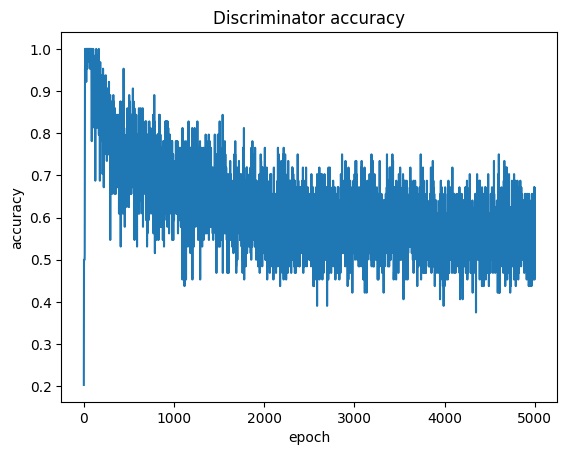

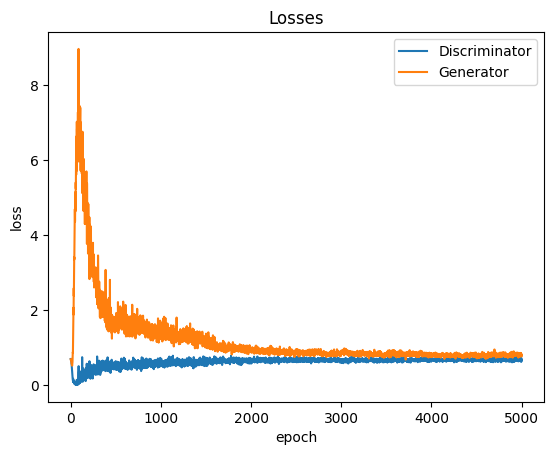

In [11]:
plt.plot(acc_plot)

plt.title('Discriminator accuracy')

plt.ylabel('accuracy')

plt.xlabel('epoch')

plt.show()



# Loss plots

plt.plot(d_loss_plot)

plt.plot(g_loss_plot)

plt.title('Losses')

plt.ylabel('loss')

plt.xlabel('epoch')

plt.legend(['Discriminator', 'Generator'])

plt.show()

In [12]:
!zip -r /content/content.zip /content/*

  adding: content/0/ (stored 0%)
  adding: content/0/2000.png (deflated 45%)
  adding: content/0/3500.png (deflated 47%)
  adding: content/0/2500.png (deflated 42%)
  adding: content/0/0.png (deflated 41%)
  adding: content/0/3000.png (deflated 48%)
  adding: content/0/1000.png (deflated 43%)
  adding: content/0/500.png (deflated 40%)
  adding: content/0/4500.png (deflated 49%)
  adding: content/0/1500.png (deflated 41%)
  adding: content/0/4000.png (deflated 49%)
  adding: content/1/ (stored 0%)
  adding: content/1/2000.png (deflated 51%)
  adding: content/1/3500.png (deflated 47%)
  adding: content/1/2500.png (deflated 47%)
  adding: content/1/0.png (deflated 40%)
  adding: content/1/3000.png (deflated 52%)
  adding: content/1/1000.png (deflated 42%)
  adding: content/1/500.png (deflated 41%)
  adding: content/1/4500.png (deflated 50%)
  adding: content/1/1500.png (deflated 44%)
  adding: content/1/4000.png (deflated 52%)
  adding: content/2/ (stored 0%)
  adding: content/2/2000.png 

In [13]:
from numpy import unique,argmax
from keras.datasets.mnist import load_data
from keras.layers import Conv2D,MaxPool2D,Dense,Flatten,Dropout
from keras.utils import plot_model
from matplotlib import pyplot
import matplotlib.pyplot as plt
import numpy as np
import os

In [21]:
# Printing Contents of a Zip File
import zipfile

with zipfile.ZipFile('/content/content.zip', 'r') as zip:
    zip.extractall('/content')

In [15]:
#Loading the Mnist dataset
(x_train1,y_train1), (x_test, y_test) = load_data()


#reshaping the training and testing data
#NOTE: update the variable 'data' array value places according to the amount of mnist data needed
# Example: To have 30k mnist dataset update as data= 30000
data = 59000
x_train_mnist = x_train1[:(data)].reshape((data, x_train1.shape[1], x_train1.shape[2], 1))
y_train_mnist = y_train1[:(data)].reshape((data,1))


print('Train', x_train_mnist.shape, y_train_mnist.shape)


x_test = x_test.reshape(x_test.shape[0],28,28,1)
y_test = y_test.reshape(y_test.shape[0],1)
print('Test', x_test.shape, y_test.shape)

Train (59000, 28, 28, 1) (59000, 1)
Test (10000, 28, 28, 1) (10000, 1)


./content/2
./content/8
./content/3
./content/9
./content/5
./content/.ipynb_checkpoints
./content/4
./content/6
./content/0
./content/1
./content/7
Train (59100, 28, 28, 1) (59100, 1)


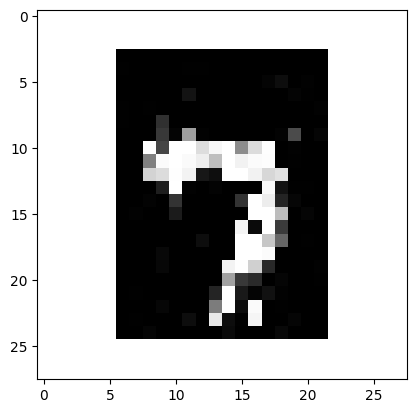

In [23]:
from keras.preprocessing import image
#from tf.image import rgb_to_grayscale
from keras.utils import load_img
#from keras.utils import load_img
from PIL import Image

#path to file containing cgan generated images
path_to_files = "./content"
vectorized_images_x = []
vectorized_images_Y = []

for _, file_num in enumerate(os.listdir(path_to_files)):
  filename = "./content/%s" % file_num
  print(filename)
  for _, file in enumerate(os.listdir(filename)):
    path = "%s/%s" % (filename,file)
    img = load_img(path,target_size=(28,28))
    plt.imshow(img,interpolation='nearest',cmap='gray')
    #plt.show()
    img1 = tf.image.rgb_to_grayscale(
    img, name=None)
    img_array = np.expand_dims(np.array(img1), axis=2)
    img_array.shape
    img_array=img_array.reshape(28,28,1)
    img_array.shape
    vectorized_images_x.append(img_array)
    vectorized_images_Y.append(int(file_num))

np.savez("./mnistlikedataset.npz",DataX=vectorized_images_x,DataY=vectorized_images_Y)
#load and use file
import numpy as np

path = "./mnistlikedataset.npz"
with np.load(path) as data:
    X_train = data['DataX']
    Y_train = data['DataY']

#Combine Mnist data and cgan generated data
Y_train = Y_train.reshape((Y_train.shape[0], 1))
x_train = np.concatenate([x_train_mnist,X_train])
y_train = np.concatenate([y_train_mnist,Y_train])
print('Train', x_train.shape, y_train.shape)

In [24]:
#normalizing the values of pixels of images
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')


/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


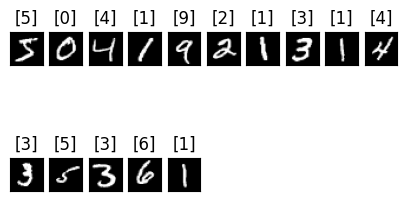

In [27]:
fig = plt.figure(figsize=(5,3))
for i in range(15):
  ax = fig.add_subplot(2,10, i+1, xticks=[], yticks=[])
  ax.imshow(np.squeeze(x_train[i]), cmap='gray')
  ax.set_title(y_train[i])

In [25]:
#determine the shape of the image
img_shape =x_train.shape[1:]
print (img_shape)
y_shape =y_train.shape[1:]
print (y_shape)


(28, 28, 1)
(1,)


In [26]:
#defining the model
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape=img_shape))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(48, (3,3), activation='relu'))
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [28]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 48)        13872     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 48)         0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 5, 5, 48)          0         
                                                                 
 flatten_3 (Flatten)         (None, 1200)             

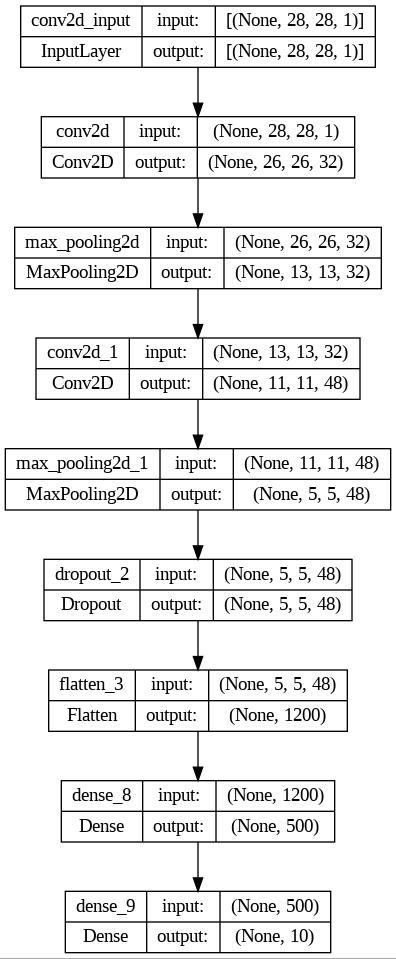

In [29]:
plot_model(model, 'model.jpg' , show_shapes=True)

In [30]:
model.compile(optimizer='adam', loss= 'sparse_categorical_crossentropy', metrics=['accuracy'])
x= model.fit(x_train, y_train, epochs=10, batch_size=128, verbose=2, validation_split=0.1)


Epoch 1/10
416/416 - 11s - loss: 1.0475 - accuracy: 0.8820 - val_loss: 0.1418 - val_accuracy: 0.9633 - 11s/epoch - 26ms/step
Epoch 2/10
416/416 - 2s - loss: 0.1494 - accuracy: 0.9542 - val_loss: 0.1416 - val_accuracy: 0.9685 - 2s/epoch - 6ms/step
Epoch 3/10
416/416 - 3s - loss: 0.1103 - accuracy: 0.9650 - val_loss: 0.1004 - val_accuracy: 0.9743 - 3s/epoch - 7ms/step
Epoch 4/10
416/416 - 3s - loss: 0.0925 - accuracy: 0.9721 - val_loss: 0.0985 - val_accuracy: 0.9731 - 3s/epoch - 7ms/step
Epoch 5/10
416/416 - 2s - loss: 0.0762 - accuracy: 0.9758 - val_loss: 0.0880 - val_accuracy: 0.9755 - 2s/epoch - 5ms/step
Epoch 6/10
416/416 - 2s - loss: 0.0667 - accuracy: 0.9791 - val_loss: 0.0756 - val_accuracy: 0.9794 - 2s/epoch - 4ms/step
Epoch 7/10
416/416 - 2s - loss: 0.0591 - accuracy: 0.9811 - val_loss: 0.0833 - val_accuracy: 0.9775 - 2s/epoch - 4ms/step
Epoch 8/10
416/416 - 2s - loss: 0.0544 - accuracy: 0.9830 - val_loss: 0.0758 - val_accuracy: 0.9792 - 2s/epoch - 4ms/step
Epoch 9/10
416/416 - 

In [31]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
model.save("classifier_cnn.h5")
print(f'Accuracy: {accuracy*100}')

Accuracy: 99.04000163078308


<function matplotlib.pyplot.show(close=None, block=None)>

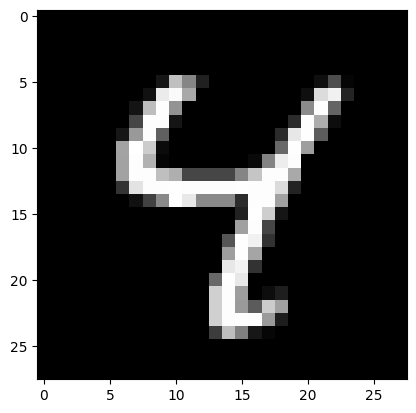

In [32]:
image = x_test[6]
#Lets display the image which we want to predicit
plt.imshow(np.squeeze(image), cmap='gray')
plt.show


In [33]:
image=image.reshape(1, image.shape[0], image.shape[1], image.shape[2])
p = model.predict([image])
print('predicted: {} '.format(argmax(p)))

1/1 [==============================] - 0s 165ms/step
predicted: 4 
